<center>  <h1> Data 598 (Winter 2022): Midterm </h1> </center> 
    <center> University of Washington </center>
    

There are 3 parts in this midterm. 
1. Optimizing a neural network
1. Explaining data science to a friend
1. Working out automatic differentiation

**Rules**:
- No collaborations allowed! You must work on your own.
- You may refer to the reference books.
- You may refer to the labs, demos, lab solutions and homework solutions. 
- However, you may not directly copy-paste code from any of the labs or demos. You should write your own code, unless explicitly noted otherwise.
- In case of clarifying questions, you may contact the instructors via direct messages on canvas.

**Advice**:
- Please consider submitting a version of your midterm 24 hours or so ahead of when it is due.  


# Part 1: Optimizing a multi-layer perceptron for audio classification
In this exercise, you will classify a short clip of audio for the musical note playing at that time. 

Along the process, you will find the divergent learning rate of the MLP and implement a variant of SGD with parameter averaging and a step decay learning rate. 

## Data loading

We will use the [MusicNet dataset](https://zenodo.org/record/5120004#.YXDPwKBlBpQ), a collection of 330 freely licensed recordings of Western classical music. This dataset was put together by John Thickstun, Zaid Harchaoui and Sham Kakade.

The task is that of music transcription. Given an audio recording of a performance, the goal is to predict the notes being played at each point in time. 

We will use a heavily subsampled and processed version of this data. Download it from [this link](https://drive.google.com/file/d/1J6BLSZRS1qmeGEYQuvw4KP8ztaQaTsZj/view?usp=sharing) and extract it the folder `./data` (132MB compressed, 189MB uncompressed). 

In [1]:
import numpy as np
import torch

root = "./data/mini-musicnet"  # Wherever the data is saved

x_train = torch.from_numpy(np.load(f"{root}/audio-train.npy"))
x_test = torch.from_numpy(np.load(f"{root}/audio-test.npy"))

y_train = torch.from_numpy(np.load(f"{root}/labels-train.npy"))
y_test = torch.from_numpy(np.load(f"{root}/labels-test.npy"))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([10136, 4096]) torch.Size([10136]) torch.Size([1911, 4096]) torch.Size([1911])


While music is inherently sequential, we ignore this temporal nature. Given a snapshot of the audio (a 9 ms audio clip, to be specific), our goal is to predict the set of notes playing at this point in time. 

We have reduced this to a multiclass classification problem with 50 classes. Each class represents a combination of notes. 

In [2]:
print("Number of classes =", np.unique(y_train).shape[0])

Number of classes = 50


## Visualize the data

We start by visualizing the raw audio, which is stored as a sequence of numbers (denoting pressure changes in the air). 

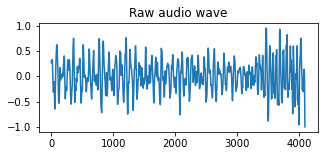

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5,2))

i = 2334

ax.set_title('Raw audio wave')
ax.plot(x_train[i])

Let us listen to the audio now. 

In [4]:
from IPython.display import Audio

Audio(x_train[2334], rate=44100) # Rate = 44.1 KHz, the usual framerate of recodings

In [5]:
Audio(x_train[1987], rate=44100)

In [6]:
# Try your own...
Audio(x_train[895], rate=44100)

## Data preprocessing

We will work with a more informative feature set using `torch.fft`. We call the resulting variables `xf_train`, `xf_test`: use only these going forward rather than the original `x_train` and `x_test`. 

In [7]:
# FFT to obtain lower-dimensional + informative features
xf_train = torch.abs(torch.fft.rfft(x_train))[:, :256]
xf_test = torch.abs(torch.fft.rfft(x_test))[:, :256]

print(xf_train.shape, xf_test.shape)

torch.Size([10136, 256]) torch.Size([1911, 256])


## Subpart A: Code up the model.

Code up a simple multi-layer perceptron (MLP) with 2 hidden layers, each of 512 dimensions. The input has 256 dimensions (because we only consider 256 coefficients), while the output contains 50 dimensions (because we have 50 classes). This can be summarized as:
$$
\text{Input} (256) \longrightarrow 512 \longrightarrow 512 \longrightarrow \text{Output} (50)
$$

Apply the ReLU activation after each linear map except the last one producing the output. 

In [8]:
from torch.nn.functional import relu, cross_entropy

class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        # Input --> Hidden 1
        self.linear_ensemble_1 = torch.nn.Sequential(
            torch.nn.Linear(in_features, 512),
            torch.nn.ReLU()
        )
        
        # Hidden 1 --> Hidden 2
        self.linear_ensemble_2 = torch.nn.Sequential(
            torch.nn.Linear(512, 512),
            torch.nn.ReLU()
        )
        
        # Hidden 2 --> Output
        self.output = torch.nn.Linear(512, out_features)
        
    
    def forward(self, x):
        out = self.linear_ensemble_1(x)  # first layer + relu
        out = self.linear_ensemble_2(out) # second layer + relu
        out = self.output(out)  # output layer
        
        return out

In [9]:
model = MultiLayerPerceptron(in_features=256, out_features=50)
num_params = sum([v.numel() for v in model.parameters()])
print(f"Number of parameters = {num_params}")  # Should be around 0.42 million

Number of parameters = 419890


## Subpart B: Code up the objective and logging. 
The objective function we will use is the multinomial logistic loss, also known in PyTorch as cross_entropy. Also code up the logging utilities to keep track of the training and testing loss and accuracy.

You may reuse code from previous labs and demos for this part (and only this part).

In [10]:
def compute_objective(model, X, y):
    """ Compute the multinomial logistic loss. 
        model is a module
        X of shape (n, d) and y of shape (n,)
    """
    score = model(X)
    return cross_entropy(input=score, target=y, reduction='mean') 

@torch.no_grad()
def compute_accuracy(model, X, y):
    """ Compute the classification accuracy
        ws is a list of tensors of consistent shapes 
        X of shape (n, d) and y of shape (n,)
    """
    score = model(X)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs(model, verbose=False):
    train_loss = compute_objective(model, xf_train, y_train)
    test_loss = compute_objective(model, xf_test, y_test)
    train_accuracy = compute_accuracy(model, xf_train, y_train)
    test_accuracy = compute_accuracy(model, xf_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    return (train_loss, train_accuracy, test_loss, test_accuracy)

## Subpart C: Implement SGD with parameter averaging. 

In addition to the model parameters $w_t$, we 
also maintain a separate set of parameters $\bar w_t$ to serve as an average. The updates of (uniformly)-averaged SGD are
$$
    w_{t+1} = w_t - \eta g_t \\
    \bar w_{t+1} = \frac{t}{t+1} \bar w_t + \frac{1}{t+1} w_{t+1},
$$
where $\eta$ is a learning rate and $g_t$ is a (minibatch) stochastic gradient at $w_t$. 
By unrolling the updates, it can be seen that 
$$
    \bar w_t = \frac{1}{t} \sum_{i=1}^t w_i
$$
is simply the iterate averaged over $t$ iterations. 

We will compute the average $\bar w_t$ over each epoch, i.e., $t=0$ corresponds to the start of the epoch. 

**Hints**:
- the update of $w_t$ is identical to the regular SGD method. That is, the averaged parameter $\bar w_t$ is *not* used during the stochastic gradient updates. 
- The averaged parameter $\bar w_t$ is updated on the side and never to be used in model updates. We use $\bar w_t$ for logging only, at the end of each epoch. 
- Remember to update the averaged parameters in-place as well! 



In [11]:
def minibatch_sgd_one_pass(model, model_avg, X, y, learning_rate, batch_size, epoch_num, verbose=False):
    # model_avg is a copy of model to store the model parameters 
    # Update its parameters to store the average \bar w
    model.train()
    num_examples = X.shape[0]
    num_updates = int(round(num_examples / batch_size))
    average_loss = 0.0
    for i in range(num_updates):
        
        idxs = np.random.choice(X.shape[0], size=(batch_size,)) # draw `batch_size` many samples
        
        # compute the objective. 
        objective = compute_objective(model, X[idxs], y[idxs])
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 50 == 0:
            print(average_loss)
        
        # compute the gradient using automatic differentiation
        gradients = torch.autograd.grad(outputs=objective, inputs=model.parameters())
        
        # perform SGD update - model. IMPORTANT: Make the update inplace!
        with torch.no_grad():
            for (w, g) in zip(model.parameters(), gradients):
                w -= learning_rate * g
                #w = 1/2*w - learning_rate * g
                
        
    # perform update for averaged model - IMPORTANT: Make the update inplace!
    with torch.no_grad():
        for j, (wbar, w) in enumerate(zip(model_avg.parameters(), model.parameters())):
            wbar *= (epoch_num / (epoch_num + 1))
            wbar += ((1 / (epoch_num + 1)) * w)
    
    return model, model_avg

## Subpart D: Divergent learning rate
Find the divergent learning rate of this model. Throughout, we use a batch size of 16. 

In [12]:
import copy

model = MultiLayerPerceptron(in_features=256, out_features=50).train()
model_avg = copy.deepcopy(model)

BATCH_SIZE = 16

learning_rate = 0.01

# Find the divergent learning rate
compute_logs(model, verbose=True)
minibatch_sgd_one_pass(model, model_avg, xf_train, y_train, learning_rate, BATCH_SIZE, epoch_num=0, verbose=True)
compute_logs(model, verbose=True)

Train Loss = 13.920, Train Accuracy = 0.013, Test Loss = 13.820, Test Accuracy = 0.009
2.0181266886256597
2.1306217091905055
2.1942681310223033
2.1419381561278192
2.069867732076296
1.9801368208431251
1.9248347091310558
1.9137212081318393
1.8496844926170004
1.788716301105552
1.723705150262407
1.6823461955162469
Train Loss = 1.549, Train Accuracy = 0.626, Test Loss = 2.146, Test Accuracy = 0.521


(tensor(1.5487), tensor(0.6256), tensor(2.1460), tensor(0.5207))

## Subpart E: Train the model using the step-decay learning rates. 

Train the model for 20 epochs at 0.25 times the divergent learning rate. 
Then, decrease the learning rate by a factor of 10 and train the model for 20 more epochs (for a total of 40 epochs). 

Create 4 plots for training and testing loss and accuracy. Each plot should contain two lines, one corresponding to the performance of the original model and the other one to the averaged model.

In [13]:
import pickle

num_epochs = 40

model = MultiLayerPerceptron(in_features=256, out_features=50).train()
model_avg = copy.deepcopy(model)

BATCH_SIZE = 16
learning_rate = 0.01 * 0.25

logs_model = []
logs_model_avg = []

print(f'Iteration 0, LR: {learning_rate}', end=', ')
logs_model.append(compute_logs(model, verbose=True))
logs_model_avg.append(compute_logs(model_avg, verbose=True))

for j in range(num_epochs):
    # step decay learning rate schedule
    num_epoch = j + 1
    if j % 20 == 0:
        learning_rate = learning_rate / 10
    
    model, model_avg = minibatch_sgd_one_pass(model, model_avg, xf_train, y_train, learning_rate, BATCH_SIZE, epoch_num=j, verbose=False)
    print(f'Iteration {num_epoch}, LR: {learning_rate}', end=', ')
    logs_model.append(compute_logs(model, verbose=True))
    logs_model_avg.append(compute_logs(model_avg, verbose=True))

with open('./models/logs_model.pkl', 'wb') as f:
    pickle.dump(logs_model, f)

with open('./models/logs_model_avg.pkl', 'wb') as f:
    pickle.dump(logs_model_avg, f)

# save the model parms
torch.save(model.state_dict(), f'./models/parms.pt')

Iteration 0, LR: 0.0025, Train Loss = 14.197, Train Accuracy = 0.023, Test Loss = 13.920, Test Accuracy = 0.023
Train Loss = 14.197, Train Accuracy = 0.023, Test Loss = 13.920, Test Accuracy = 0.023
Iteration 1, LR: 0.00025, Train Loss = 2.040, Train Accuracy = 0.549, Test Loss = 2.545, Test Accuracy = 0.454
Train Loss = 2.040, Train Accuracy = 0.549, Test Loss = 2.545, Test Accuracy = 0.454
Iteration 2, LR: 0.00025, Train Loss = 1.641, Train Accuracy = 0.612, Test Loss = 2.288, Test Accuracy = 0.503
Train Loss = 1.770, Train Accuracy = 0.591, Test Loss = 2.348, Test Accuracy = 0.489
Iteration 3, LR: 0.00025, Train Loss = 1.449, Train Accuracy = 0.645, Test Loss = 2.215, Test Accuracy = 0.510
Train Loss = 1.613, Train Accuracy = 0.614, Test Loss = 2.259, Test Accuracy = 0.502
Iteration 4, LR: 0.00025, Train Loss = 1.284, Train Accuracy = 0.673, Test Loss = 2.161, Test Accuracy = 0.530
Train Loss = 1.494, Train Accuracy = 0.635, Test Loss = 2.204, Test Accuracy = 0.514
Iteration 5, LR: 

# Part 2:  Explaining data science to a friend

Murphy is a colleague of yours, who is hooked to social media, fascinated by intelligent systems using deep learning, and listens to Taylor Swift from time to time.

Murphy says that, in order to tune the step-size of a stochastic gradient algorithm, one must use the largest step-size that does not incur divergence. To Murphy, divergence is a space-time singularity that makes space and time travel possible. In other words, the appropriate step-size is the largest step-size that does not result in a space-time singularity that would transport the programmer and the software into another space and another time.

What do you think of Murphy's perception? What would you tell Murphy so that they can train deep networks effectively?


**Response**: TODO

# Part 3: Working out automatic differentiation

Consider the function $f: \mathbb{R}_+ \to \mathbb{R}$ defined as 

$$
    f(x) =  \Big( 2.5 + x^{3} + \exp (2.5 + x^{3})\Big)^2 + \log\left(2.5 + x^{3} + \exp (2.5 + x^{3})\right) .
$$


## Questions:
**A)** Draw the the computation graph of this function. Try to reuse as many intermediate variables as possible. 

You may draw the graph using PowerPoint, Keynote, GIMP or any other software and insert it here in this Markdown cell. 


**Your answer here**:
![<text to display if figure not found>](name_of_figure.jpg)
    
**B)** Write out the chain rule to compute the derivative $f'(x)$ of $f$ at a given $x$. 
You may insert the equations in Markdown directly using LaTeX syntax. 

**Your answer here**: 



**C)** Implement this function $f$ in code so that it accepts a scalar $x$ and returns $f(x)$. 

In [14]:
import torch
def my_function(x):
    # x is a torch.tensor (this is the PyTorch scalar type)
    # as opposed to torch.Tensor, which is the array version (note: tensor vs. Tensor)
    # Example input `x = torch.tensor(3.14159, requires_grad=True)`
    # TODO: your code here

SyntaxError: unexpected EOF while parsing (2524814706.py, line 6)

**D)** Compute the derivative $f'(x)$ for $x= 0.01$ using PyTorch's automatic differentiation. You do not have to code up your own backward method. 

In [ ]:
# TODO: your code here